# ML Surrogates for Chemical ODEs in Astrochemistry
Welcome! In this notebook, we simulate a simple astrochemical ODE system and train three different ML models to approximate its behavior:
- Feedforward Neural Network (FNN)
- Neural ODE
- Deep Operator Network (DeepONet)

We'll compare their performance as surrogates for the underlying physical dynamics.

**Author:** Lorenzo Branca  
**Date:** July 2025

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt
import optax
%matplotlib inline

## Simulating a Toy Chemical Reaction System

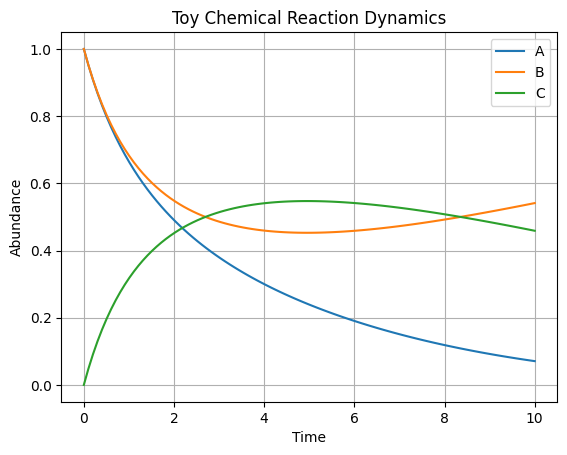

In [2]:
def reaction_system(t, y, args):
    A, B, C = y
    k1, k2 = args
    dA = -k1 * A * B
    dB = -k1 * A * B + k2 * C
    dC = k1 * A * B - k2 * C
    return jnp.array([dA, dB, dC])

y0 = jnp.array([1.0, 1.0, 0.0])
k1, k2 = 0.5, 0.1
t0, t1 = 0.0, 10.0
ts = jnp.linspace(t0, t1, 100)

term = ODETerm(reaction_system)
solver = Dopri5()
saveat = SaveAt(ts=ts)
sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=0.1, y0=y0, args=(k1, k2), saveat=saveat)

plt.plot(ts, sol.ys[:, 0], label="A")
plt.plot(ts, sol.ys[:, 1], label="B")
plt.plot(ts, sol.ys[:, 2], label="C")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.title("Toy Chemical Reaction Dynamics")
plt.legend()
plt.grid(True)

## Generate Training Data

In [35]:
def generate_dataset(n_samples=200, key=jax.random.PRNGKey(0)):
    ic_list, traj_list = [], []

    # Sample random initial conditions in [0, 1]^3
    ic_samples = jax.random.uniform(key, shape=(n_samples, 3), minval=0.0, maxval=1.0)

    for i in range(n_samples):
        y0 = ic_samples[i]
        sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=0.1, y0=y0, args=(k1, k2), saveat=saveat)
        ic_list.append(y0)
        traj_list.append(sol.ys)

    return jnp.stack(ic_list), ts[None, :].repeat(n_samples, axis=0), jnp.stack(traj_list)

ICs, Ts, Ys = generate_dataset(n_samples= 1024)

## Next Steps

Now that we have generated the data, we will:

1. Implement and train a **Feedforward Neural Network (FNN)**.
2. Implement and train a **Neural ODE** model.
3. Implement and train a **DeepONet** model.
4. Compare their performance.

⬇️ Continue by implementing the FNN model below ⬇️

## 🔧 Implementing the Feedforward Neural Network (FNN)
We'll use a simple MLP that takes `[IC, t]` as input and predicts `[A, B, C]`.

In [36]:
from flax import linen as nn
from dataclasses import field
from typing import List

class FNN(nn.Module):
    hidden_dims: List[int] = field(default_factory=lambda: [128, 128, 128])

    @nn.compact
    def __call__(self, ic, t):
        B, N = t.shape
        x = jnp.concatenate([jnp.repeat(ic[:, None, :], N, axis=1), t[:, :, None]], axis=-1)
        x = x.reshape(-1, x.shape[-1])  # (B*N, features)
        for h in self.hidden_dims:
            x = nn.relu(nn.Dense(h)(x))
        out = nn.Dense(3)(x)
        return out.reshape(B, N, 3)

### 🔁 Training loop for FNN

In [37]:
import optax
from flax.training import train_state

class TrainState(train_state.TrainState):
    pass

def create_train_state(rng, model, lr=1e-3):
    params = model.init(rng, ICs[:1], Ts[:1])['params']
    tx = optax.adam(learning_rate=lr)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def loss_fn(params, apply_fn, ic, t, y_true):
    y_pred = apply_fn({'params': params}, ic, t)
    return jnp.mean((y_pred - y_true)**2)

@jax.jit
def train_step(state, ic, t, y_true):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, ic, t, y_true)
    return state.apply_gradients(grads=grads), loss

### 🚀 Train the model

In [38]:
rng = jax.random.PRNGKey(0)
model = FNN()
state = create_train_state(rng, model)

n_epochs = 200
batch_size = 32
losses = []

for epoch in range(n_epochs):
    idx = jax.random.permutation(rng, ICs.shape[0])
    ICs_shuffled, Ts_shuffled, Ys_shuffled = ICs[idx], Ts[idx], Ys[idx]

    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs_shuffled[i:i+batch_size]
        t_batch = Ts_shuffled[i:i+batch_size]
        y_batch = Ys_shuffled[i:i+batch_size]
        state, loss = train_step(state, ic_batch, t_batch, y_batch)
        epoch_loss += loss

    epoch_loss /= (ICs.shape[0] // batch_size)
    losses.append(epoch_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {epoch_loss:.4e}")

Epoch 0, Loss = 1.0175e-01
Epoch 20, Loss = 2.4363e-04
Epoch 40, Loss = 2.0998e-04
Epoch 60, Loss = 2.7467e-04
Epoch 80, Loss = 1.6897e-04
Epoch 100, Loss = 7.0865e-05
Epoch 120, Loss = 1.5760e-04
Epoch 140, Loss = 7.1036e-05
Epoch 160, Loss = 8.6533e-05
Epoch 180, Loss = 1.1478e-04


### 📈 Visualize predictions vs. ground truth

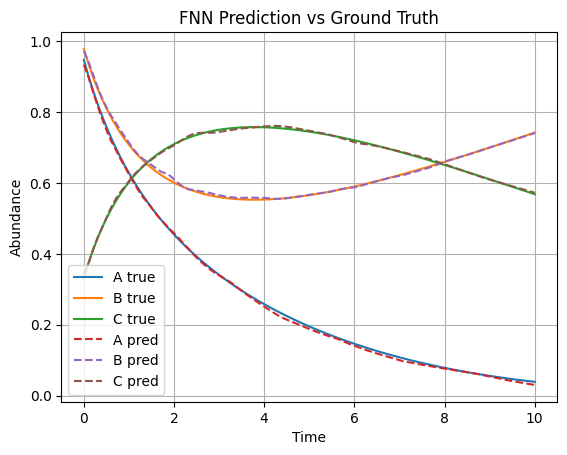

In [39]:
# Pick a test sample
idx = 0
ic_test = ICs[idx:idx+1]
t_test = Ts[idx:idx+1]
y_true = Ys[idx]

y_pred = model.apply({'params': state.params}, ic_test, t_test)[0]

plt.plot(ts, y_true[:, 0], label="A true")
plt.plot(ts, y_true[:, 1], label="B true")
plt.plot(ts, y_true[:, 2], label="C true")
plt.plot(ts, y_pred[:, 0], '--', label="A pred")
plt.plot(ts, y_pred[:, 1], '--', label="B pred")
plt.plot(ts, y_pred[:, 2], '--', label="C pred")
plt.legend()
plt.title("FNN Prediction vs Ground Truth")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.grid(True)


## 🧠 Implementing the Neural ODE Surrogate
We will define a neural network as the right-hand side of the ODE system and use it inside a `diffrax` solver.

In [40]:
class NeuralODEFunc(nn.Module):
    hidden_dims: List[int] = field(default_factory=lambda: [64, 64])

    @nn.compact
    def __call__(self, t, y, args=None):
        x = y
        for h in self.hidden_dims:
            x = nn.relu(nn.Dense(h)(x))
        return nn.Dense(3)(x)

In [41]:
def solve_neural_ode(rhs_net, params, y0, ts):
    term = ODETerm(lambda t, y, args: rhs_net.apply({'params': params}, t, y))
    solver = Dopri5() # play with rtol and atol
    saveat = SaveAt(ts=ts)
    sol = diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.1, y0=y0, saveat=saveat)
    return sol.ys

In [42]:
# Initialize
neural_ode_model = NeuralODEFunc()
rng, key = jax.random.split(rng)
neural_ode_params = neural_ode_model.init(key, 0.0, jnp.array([1.0, 1.0, 0.0]))['params']

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(neural_ode_params)

In [43]:
from functools import partial


@jax.jit
def ode_loss_fn(params, model, y0, ts, y_true):
    pred_y = solve_neural_ode(model, params, y0, ts)
    return jnp.mean((pred_y - y_true) ** 2)

def make_ode_train_step(model):
    @jax.jit
    def ode_train_step(params, opt_state, y0_batch, ts, y_batch):
        def loss_fn(params):
            pred_y = solve_neural_ode(model, params, y0_batch, ts)  # shape: (T, B, D)
            pred_y = jnp.swapaxes(pred_y, 0, 1)  # -> shape: (B, T, D), to match y_batch
            return jnp.mean((pred_y - y_batch) ** 2)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    return ode_train_step


In [44]:
n_epochs = 100
ode_losses = []

# Compile this only once before training loop
ode_train_step = make_ode_train_step(neural_ode_model)


for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs[i : i + batch_size]   
        y_batch = Ys[i : i + batch_size]    

        neural_ode_params, opt_state, loss = ode_train_step(
            neural_ode_params, opt_state, ic_batch, ts, y_batch
        )

        epoch_loss += loss

    epoch_loss /= (ICs.shape[0] // batch_size)
    ode_losses.append(epoch_loss)

    if epoch % 20 == 0:
        print(f"[NeuralODE] Epoch {epoch}, Loss = {epoch_loss:.4e}")


[NeuralODE] Epoch 0, Loss = 1.6597e-01
[NeuralODE] Epoch 20, Loss = 3.2167e-04
[NeuralODE] Epoch 40, Loss = 1.3216e-04
[NeuralODE] Epoch 60, Loss = 9.7170e-05
[NeuralODE] Epoch 80, Loss = 9.1809e-05


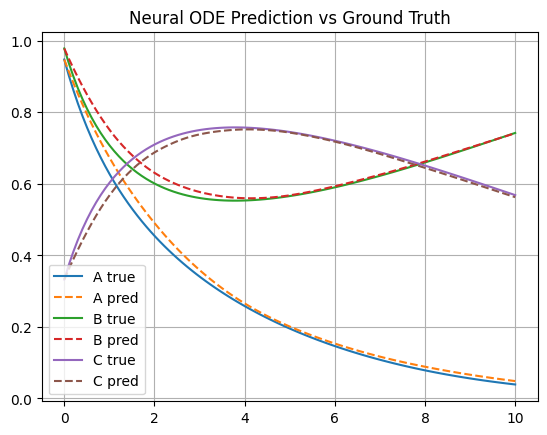

In [45]:
# Plot prediction
y0_test = ICs[0]
y_true = Ys[0]
y_pred = solve_neural_ode(neural_ode_model, neural_ode_params, y0_test, ts)

plt.plot(ts, y_true[:, 0], label="A true")
plt.plot(ts, y_pred[:, 0], '--', label="A pred")
plt.plot(ts, y_true[:, 1], label="B true")
plt.plot(ts, y_pred[:, 1], '--', label="B pred")
plt.plot(ts, y_true[:, 2], label="C true")
plt.plot(ts, y_pred[:, 2], '--', label="C pred")
plt.legend()
plt.title("Neural ODE Prediction vs Ground Truth")
plt.grid(True)

## 🧬 Implementing DeepONet
We now define a Deep Operator Network with separate branch and trunk networks.

In [46]:
import jax.numpy as jnp
from flax import linen as nn
from typing import Callable, Tuple

class MLP(nn.Module):
    features: Tuple[int, ...]
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        return nn.Dense(self.features[-1])(x)

class DeepONet(nn.Module):
    branch_layers: Tuple[int, ...] = (128, 128, 128)
    trunk_layers: Tuple[int, ...] = (128, 128, 128)
    latent_dim: int = 128
    output_dim: int = 3
    activation: Callable = nn.tanh

    def setup(self):
        trunk_features = self.trunk_layers + (self.latent_dim,)
        self.trunk_net = MLP(features=trunk_features, activation=self.activation)

        # Define 3 separate branch networks
        self.branch_nets = [
            MLP(features=self.branch_layers + (self.latent_dim,), activation=self.activation)
            for _ in range(self.output_dim)
        ]

    @nn.compact
    def __call__(self, ic, t):
        B, N = t.shape  # B=batch size, N=time points
        trunk_in = t.reshape(-1, 1)  # (B*N, 1)
        trunk_out = self.trunk_net(trunk_in).reshape(B, N, self.latent_dim)  # (B, N, D)

        # For each branch network, compute output and dot with trunk
        outputs = []
        for branch_net in self.branch_nets:
            branch_out = branch_net(ic).reshape(B, self.latent_dim)  # (B, D)
            y = jnp.einsum("bnd,bd->bn", trunk_out, branch_out)  # (B, N)
            outputs.append(y[..., None])  # (B, N, 1)

        return jnp.concatenate(outputs, axis=-1)  # (B, N, 3)



In [47]:
deeponet_model = DeepONet()
deeponet_state = create_train_state(rng, deeponet_model)

def deeponet_loss_fn(params, ic, t, y_true):
    y_pred = deeponet_model.apply({'params': params}, ic, t)
    return jnp.mean((y_pred - y_true) ** 2)

@jax.jit
def deeponet_train_step(state, ic, t, y_true):
    loss, grads = jax.value_and_grad(deeponet_loss_fn)(state.params, ic, t, y_true)
    return state.apply_gradients(grads=grads), loss

In [48]:
n_epochs = 200
deeponet_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs[i:i+batch_size]
        t_batch = Ts[i:i+batch_size]
        y_batch = Ys[i:i+batch_size]
        deeponet_state, loss = deeponet_train_step(deeponet_state, ic_batch, t_batch, y_batch)
        epoch_loss += loss
    epoch_loss /= (ICs.shape[0] // batch_size)
    deeponet_losses.append(epoch_loss)
    if epoch % 20 == 0:
        print(f"[DeepONet] Epoch {epoch}, Loss = {epoch_loss:.4e}")

[DeepONet] Epoch 0, Loss = 1.3680e+00
[DeepONet] Epoch 20, Loss = 4.0996e-04
[DeepONet] Epoch 40, Loss = 3.5201e-04
[DeepONet] Epoch 60, Loss = 3.2080e-04
[DeepONet] Epoch 80, Loss = 3.4890e-04
[DeepONet] Epoch 100, Loss = 3.1062e-04
[DeepONet] Epoch 120, Loss = 1.9963e-04
[DeepONet] Epoch 140, Loss = 1.6677e-04
[DeepONet] Epoch 160, Loss = 1.9040e-04
[DeepONet] Epoch 180, Loss = 1.3654e-04


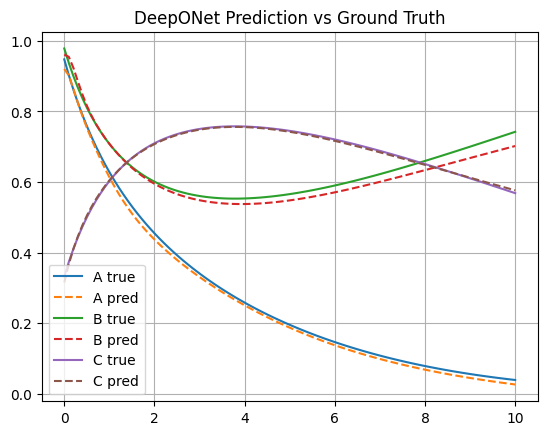

In [49]:
# Evaluate DeepONet
ic_test = ICs[0:1]
t_test = Ts[0:1]
y_true = Ys[0]
y_pred = deeponet_model.apply({'params': deeponet_state.params}, ic_test, t_test)[0]

plt.plot(ts, y_true[:, 0], label="A true")
plt.plot(ts, y_pred[:, 0], '--', label="A pred")
plt.plot(ts, y_true[:, 1], label="B true")
plt.plot(ts, y_pred[:, 1], '--', label="B pred")
plt.plot(ts, y_true[:, 2], label="C true")
plt.plot(ts, y_pred[:, 2], '--', label="C pred")
plt.legend()
plt.title("DeepONet Prediction vs Ground Truth")
plt.grid(True)